In [442]:
#from disqusapi import DisqusAPI
from pymongo import MongoClient
import pandas as pd
import numpy as np
import time
import random
import string
import unicodedata
import gensim
import re
import pickle
import pprint
import spacy
import operator
import nltk
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from textblob import TextBlob
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from nltk.cluster.kmeans import KMeansClusterer
from nltk.sentiment import vader
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [126]:
%matplotlib inline

In [93]:
# percentage format
def form_percent(val, digits):
    return '{1:.{0}f}%'.format(digits, val * 100)

# Gathering Data from Disqus

To get our data, we'll use the Disqus API and query the API for each of our websites.

The websites we'll use are:

Alt-Right:
- Breitbart (breitbart.com)
- American Renassiance (amren.com)
- Altright (altright.com)

Social Justice Left:
- Alternet (alternet.org)
- Crooks and Liars (crooksandliars.com)
- Gopocalypse (gopocalypse.org)
- Towleroad (towleroad.com)

In [2]:
# Disqus generate API key, see https://disqus.com/api/applications/5306746/
# Note that in order to generate an API key you must first create an "app" in Disqus, which just gives you access to an API key
public_api_key = 'l13mhGakC3gmiD1mTHn5sS9V5P3s1pc69K5n2PLczV7E2pXMGKrJ3fKnfLC3dKfk'

In [3]:
# Generate an DisqusAPI object for querying
disqus = DisqusAPI(public_key=public_api_key)

##### Side note: If you want to specify a specific article in your API call, include a 'thread' parameter in your disqus.get with the following format

In [4]:
thread_url = r'link:http://www.breitbart.com/tech/2016/03/29/an-establishment-conservatives-guide-to-the-alt-right/'

##### Each website using Disqus is referred to by Disqus as a 'forum', and each forum has an associated unique name

These names can be found by inspecting the html on a page with Disqus and searching for the disqusshortname

In [325]:
altright_forum = 'altright-com'
alternet_forum = 'alternet'
amren_forum = 'americanrenaissance'
breitbart_forum = 'breitbartproduction'
candl_forum = 'candl'
gopocalypse_forum = 'gopocalypse'
towleroad_forum = 'towleroad'

forums =[altright_forum, alternet_forum, amren_forum, breitbart_forum, candl_forum, gopocalypse_forum, towleroad_forum]

##### The following is an example API call, just to have as an example and see how/what is returned

In [326]:
test_response = disqus.get('posts/list', method = "GET", version ='3.0', forum = gopocalypse_forum, related = 'thread',
                                    limit = 5, since = "2016-06-01T00:00:00", order = "asc")

In [327]:
# get each post as a list
list_of_posts = response.response

In [328]:
# sample post
list_of_posts[0]

{'author': {'about': '',
  'avatar': {'cache': 'https://c.disquscdn.com/uploads/users/1214/3522/avatar92.jpg?1502837603',
   'isCustom': True,
   'large': {'cache': 'https://c.disquscdn.com/uploads/users/1214/3522/avatar92.jpg?1502837603',
    'permalink': 'https://disqus.com/api/users/avatars/ErnestMcLeod.jpg'},
   'permalink': 'https://disqus.com/api/users/avatars/ErnestMcLeod.jpg',
   'small': {'cache': 'https://c.disquscdn.com/uploads/users/1214/3522/avatar32.jpg?1502837603',
    'permalink': 'https://disqus.com/api/users/avatars/ErnestMcLeod.jpg'}},
  'disable3rdPartyTrackers': False,
  'id': '12143522',
  'isAnonymous': False,
  'isPowerContributor': False,
  'isPrimary': True,
  'isPrivate': False,
  'joinedAt': '2011-06-09T17:39:22',
  'location': '',
  'name': 'ErnestMc',
  'profileUrl': 'https://disqus.com/by/ErnestMcLeod/',
  'signedUrl': '',
  'url': '',
  'username': 'ErnestMcLeod'},
 'canVote': False,
 'createdAt': '2016-10-25T01:53:31',
 'dislikes': 0,
 'forum': 'towlero

##### Now that we know how the posts are returned, we can create some loops to go out and get all the data

In [329]:
# helper function that converts a post to a Python dictionary with only the relevant data
# we'll store each result as a mongoDB document, with each website as a collection
def genereate_post_data(post):
    post_dict = {}
    post_dict['comment_id'] = post['id']
    post_dict['name'] = post['author']['name']
    if 'id' in post['author'].keys(): # id is occasionally missing
        post_dict['user_id'] = post['author']['id']
    else:
        post_dict['user_id'] = None
    post_dict['message'] = post['raw_message']
    post_dict['thread_title'] = post['thread']['clean_title']
    post_dict['thread_link'] = post['thread']['link']
    post_dict['thread_id'] = post['thread']['id']
    post_dict['thread_post_count'] = post['thread']['posts']
    
    return post_dict

In [42]:
# get our MongoClient object
client = MongoClient()

##### Connect to the local mongo database and create the necessary collections

In [6]:
# what databases are out there
client.database_names()

['admin', 'local']

In [43]:
# connect to the 'local' database
local_db = client.get_database('local')

In [6]:
local_db.collection_names()

['amren',
 'altright',
 'candl',
 'alternet',
 'main_altright',
 'test',
 'startup_log',
 'main_sjleft',
 'breitbart',
 'gopocalypse',
 'towleroad']

In [310]:
# create each collection, if doesn't already exist, otherwise, access it
alternet    = local_db['alternet']    if 'alternet'    in local_db.collection_names() else local_db.create_collection('alternet')
altright    = local_db['altright']    if 'altright'    in local_db.collection_names() else local_db.create_collection('altright')
amren       = local_db['amren']       if 'amren'       in local_db.collection_names() else local_db.create_collection('amren')
breitbart   = local_db['breitbart']   if 'breitbart'   in local_db.collection_names() else local_db.create_collection('breitbart')
candl       = local_db['candl']       if 'candl'       in local_db.collection_names() else local_db.create_collection('candl')
gopocalypse = local_db['gopocalypse'] if 'gopocalypse' in local_db.collection_names() else local_db.create_collection('gopocalypse')
towleroad   = local_db['towleroad']   if 'towleroad'   in local_db.collection_names() else local_db.create_collection('towleroad')

##### Now do our loop and collect the data from each website - preferably 50,000 comments if available

In [362]:
# generate and eventually save the cursors from each website API call, so that we can start off where we left off, if we 
# eventually decide to get more comments
amren_next_cursor       = '1470788631881110:0:0'
altright_next_cursor    = '1502847296850633:0:0'
alternet_next_cursor    = '1466214349013896:0:0'
breitbart_next_cursor   = '1464815501814339:0:0'
candl_next_cursor       = '1466094639062843:0:0'
gopocalypse_next_cursor = '1497222027672180:0:0'
towleroad_next_cursor   = '1477417163140979:0:0'

In [363]:
# create a dictionary that associates forums with mongoDB collections, as those are the only two variables that change as
# we iterate through our websites
websites = [
    {'forum': 'altright-com',        'collection': 'altright',    'cursor': altright_next_cursor},
    {'forum': 'alternet',            'collection': 'alternet',    'cursor': alternet_next_cursor},
    {'forum': 'americanrenaissance', 'collection': 'amren',       'cursor': amren_next_cursor},
    {'forum': 'breitbartproduction', 'collection': 'breitbart',   'cursor': breitbart_next_cursor},
    {'forum': 'candl',               'collection': 'candl',       'cursor': candl_next_cursor},
    {'forum': 'gopocalypse',         'collection': 'gopocalypse', 'cursor': gopocalypse_next_cursor},
    {'forum': 'towleroad',           'collection': 'towleroad',   'cursor': towleroad_next_cursor}
]

In [364]:
for website in websites:
    print(f"Collection: {website['collection']}, Forum: {website['forum']}, Cursor: {website['cursor']}")

Collection: altright, Forum: altright-com, Cursor: 1502847296850633:0:0
Collection: alternet, Forum: alternet, Cursor: 1466214349013896:0:0
Collection: amren, Forum: americanrenaissance, Cursor: 1470788631881110:0:0
Collection: breitbart, Forum: breitbartproduction, Cursor: 1464815501814339:0:0
Collection: candl, Forum: candl, Cursor: 1466094639062843:0:0
Collection: gopocalypse, Forum: gopocalypse, Cursor: 1497222027672180:0:0
Collection: towleroad, Forum: towleroad, Cursor: 1477417163140979:0:0


In [ ]:
for website in websites: # use our forum list as a proxy 
    count = 0
    has_next = True
    start_time = time.time()
    next_cursor = website['cursor']
    print(f"Collecting {website['collection']} comments:")

    while count < 50000 and has_next:
    
        if local_db[website['collection']].count() != 0 and next_cursor:
            response = disqus.get('posts/list', method = "GET", version ='3.0', forum = website['forum'], related = 'thread',
                                        limit = 100, since = "2016-06-01T00:00:00", order = "asc", cursor = next_cursor)
        else:
            response = disqus.get('posts/list', method = "GET", version ='3.0', forum = website['forum'], related = 'thread',
                                        limit = 100, since = "2016-06-01T00:00:00", order = "asc")

        if response.cursor['hasNext']:
            next_cursor = response.cursor['next']
        else:
            has_next = False
            print('has_next is False')

        list_of_posts = response.response

        for post in list_of_posts:
            local_db[website['collection']].insert_one(genereate_post_data(post))
            count += 1

        print(f"Number of {website['collection']} comments collected: {local_db[website['collection']].count()}")

    website['cursor'] = next_cursor
    print(f"{website['collection']} collection complete.")
    print("-- {} s --".format(time.time() - start_time))

##### Alright, now we have all our data! Let's just confirm that we have the amount of comments we're looking for (and that they're all unique), then we can move on to cleaning and analysis

In [384]:
for website in websites:
    comment_ids = set()
    
    for doc in local_db[website['collection']].find():
        comment_ids.add(doc['comment_id'])
        
    print(f"Site: {website['collection']} {' ' * (12 - len(website['collection']))} Post Count: {local_db[website['collection']].count()} Unique Comment IDs: {len(comment_ids)}")

Site: altright      Post Count: 47313 Unique Comment IDs: 47313
Site: alternet      Post Count: 50000 Unique Comment IDs: 50000
Site: amren         Post Count: 50000 Unique Comment IDs: 50000
Site: breitbart     Post Count: 50000 Unique Comment IDs: 50000
Site: candl         Post Count: 50000 Unique Comment IDs: 50000
Site: gopocalypse   Post Count: 3783 Unique Comment IDs: 3783
Site: towleroad     Post Count: 50000 Unique Comment IDs: 50000


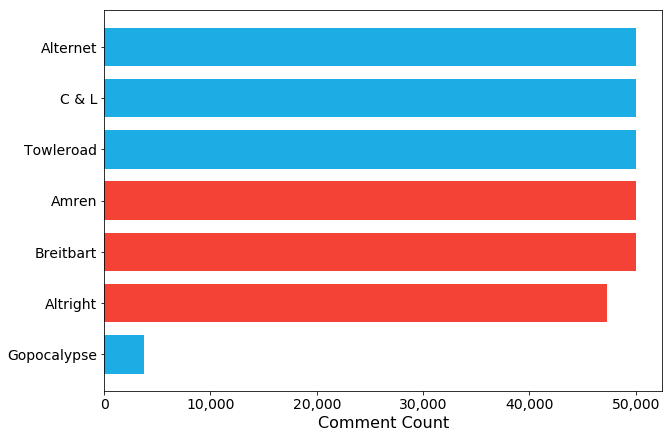

In [525]:
N = 7

ind = np.arange(N)  # the x locations for the groups
width = 0.75       # the width of the bars

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
rects2 = ax.barh(ind+width, [3783,47313,50000,50000,50000,50000,50000], width, color=['#1CADE4','#F44336','#F44336','#F44336','#1CADE4','#1CADE4','#1CADE4'])

# add some
ax.set_xlabel('Comment Count', fontsize=16)
ax.set_yticks(ind+width)
ax.set_yticklabels( ('Gopocalypse','Altright', 'Breitbart', 'Amren', 'Towleroad', 'C & L', 'Alternet'), fontsize=16 )
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

# Clean the data

First let's combine each of the alt-right and social justice left websites into two collections that we'll clean

In [ ]:
# if we mess up cleaning the data, remove docs here
# main_altright.remove()
# main_sjleft.remove()

In [44]:
main_altright = local_db['main_altright'] if 'main_altright' in local_db.collection_names() else local_db.create_collection('main_altright')
main_sjleft   = local_db['main_sjleft']   if 'main_sjleft'   in local_db.collection_names() else local_db.create_collection('main_sjleft')

In [1298]:
for doc in amren.find():
    main_altright.insert_one(doc)
    
for doc in altright.find():
    main_altright.insert_one(doc)
    
for doc in breitbart.find():
    main_altright.insert_one(doc)
    
for doc in candl.find():
    main_sjleft.insert_one(doc)
    
for doc in alternet.find():
    main_sjleft.insert_one(doc)
    
for doc in gopocalypse.find():
    main_sjleft.insert_one(doc)
    
for doc in towleroad.find():
    main_sjleft.insert_one(doc)

##### Let's combine the current set of comments into one giant list so we can randomly go through it just to get a feel for the comments

In [9]:
comments = []

for post in main_altright.find():
    comments.append(post['message'])
for post in main_sjleft.find():
    comments.append(post['message'])

In [18]:
rand_comment_1 = comments[random.randint(0, (main_altright.count() + main_sjleft.count()))]
rand_comment_2 = comments[random.randint(0, (main_altright.count() + main_sjleft.count()))]
rand_comment_3 = comments[random.randint(0, (main_altright.count() + main_sjleft.count()))]

print(rand_comment_1, '\n\n\n')
print(rand_comment_2, '\n\n\n')
print(rand_comment_3)

hilarious fat looser in his mom's basement telling me to be afraid because i love my countrythis fat disgusting mentally ill slob could not even walk the length of my driveway to get his ass beat up one side and down the other from this 49 year old lady 



this could very easily be low-iq dindus being set up by an informant i mean how many blacks have ever heard of istanbul how many know it's in turkeyand how many know you can take a train from berlin to istanbul 



why does anyone follow what cernovitch is up to he's clearly a plant and just did a psyop on the alt-right


##### Clean Up 1:
1. Any posts with less than 4 spaces
    - This should clear out any super short comments, as well as comment that consists solely of a link, or gibberish
2. Any post less than 20 characters in length

##### First for altright:

In [1301]:
# add in field for comment length
for doc in main_altright.find():
    main_altright.update_one({'_id': doc['_id']}, {'$set': {'comment_len': len(doc['message'])}})

In [1302]:
altright_length_delete_result = main_altright.delete_many({'comment_len': {'$lte': 20}})

In [1303]:
altright_length_delete_result.deleted_count

7399

In [1304]:
spaces_delete_count = 0

for doc in main_altright.find():
    spaces_count = doc['message'].count(' ')
    if spaces_count < 4:
        main_altright.delete_one({'_id': doc['_id']})
        spaces_delete_count += 1
        
print(spaces_delete_count)

4126


##### Now for social justice left:

In [1305]:
# add in field for comment length
for doc in main_sjleft.find():
    main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'comment_len': len(doc['message'])}})

In [1306]:
sjl_length_delete_result = main_sjleft.delete_many({'comment_len': {'$lte': 20}})

In [1307]:
sjl_length_delete_result.deleted_count

8114

In [1308]:
spaces_delete_count = 0

for doc in main_sjleft.find():
    spaces_count = doc['message'].count(' ')
    if spaces_count < 4:
        main_sjleft.delete_one({'_id': doc['_id']})
        spaces_delete_count += 1
        
print(spaces_delete_count)

4334


##### Clean Up 2:
1. Convert everything to lowercase
2. Remove any hyperlinks
3. Remove any html text formatting, adding a field for percentage of comment that's bold or italicized

In [1309]:
# convert all to lowercase
for doc in main_altright.find():
    lower_message = doc['message'].lower()
    main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': lower_message}})
    
for doc in main_sjleft.find():
    lower_message = doc['message'].lower()
    main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': lower_message}})

In [1469]:
# remove hyperlinks
for doc in main_altright.find():
    if 'http' in doc['message']:
        link_start =   doc['message'].index('http')
        try:
            link_end = doc['message'].index(' ', link_start)
        except:
            link_end = len(doc['message'])
            
        cleaned_message = doc['message'][:link_start] + doc['message'][link_end:]
        main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
        
for doc in main_sjleft.find():
    if 'http' in doc['message']:
        link_start =   doc['message'].index('http')
        try:
            link_end = doc['message'].index(' ', link_start)
        except:
            link_end = len(doc['message'])
            
        cleaned_message = doc['message'][:link_start] + doc['message'][link_end:]
        main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

In [1470]:
# confirm all the hyperlinks are gone
altright_http_count = 0
sjleft_http_count = 0

for doc in main_altright.find():
    if 'http' in doc['message']:
        altright_http_count += 1
        #print(doc['message'])
        
for doc in main_sjleft.find():
    if 'http' in doc['message']:
        sjleft_http_count += 1
        #print(doc['comment_id'], doc['message'])
        
print(altright_http_count)
print(sjleft_http_count)

0
0


In [1542]:
# remove html tags from comment, and add percentage of text that was contained within tag, if desired
def remove_html(collection, document, html_tag, add_field=False):
    tag_count = document['message'].count('<' + html_tag + '>')
    tagged_chars = 0
    html_start = 0
    html_end = 0

    if add_field:
        for _ in range(tag_count):
            try:
                html_start = document['message'].index('<' + html_tag + '>', html_end)
            except:
                html_start = len(document['message'])
            try:
                html_end = document['message'].index('</' + html_tag + '>', html_start)
            except:
                html_end = len(document['message'])
            tagged_chars += html_end - html_start

        local_db[collection].update_one({'_id': document['_id']}, 
                                        {'$set': {'percent_html_' + html_tag: tagged_chars / len(document['message'])}})
        
    cleaned_message = document['message'].replace('<' + html_tag + '>', '').replace('</' + html_tag + '>', '')
    local_db[collection].update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

In [ ]:
# remove italics tag, and add a field for percentage of text that was italicized
for doc in main_altright.find():
    remove_html('main_altright', doc, 'i', add_field=True)
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'i', add_field=True)

In [ ]:
# remove blockquotes tag
for doc in main_altright.find():
    remove_html('main_altright', doc, 'blockquote')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'blockquote')

In [1534]:
# remove bold tag
for doc in main_altright.find():
    remove_html('main_altright', doc, 'b', add_field=True)
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'b', add_field=True)

In [1536]:
# remove em tag
for doc in main_altright.find():
    remove_html('main_altright', doc, 'em')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'em')

In [1538]:
# remove s and u tag
for doc in main_altright.find():
    remove_html('main_altright', doc, 's')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 's')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'u')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'u')

In [1540]:
# remove p tag
for doc in main_altright.find():
    remove_html('main_altright', doc, 'p')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'p')

In [1543]:
# remove misc tags that might not even be html but that people are using weird
for doc in main_altright.find():
    remove_html('main_altright', doc, 'sarcasm')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'sarcasm')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'strike')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'strike')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'racism')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'racism')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'strong')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'strong')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'a')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'a')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'br')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'br')

In [1545]:
# alright let's get a few more
for doc in main_altright.find():
    remove_html('main_altright', doc, 'head')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'head')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'title')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'title')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'spoiler')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'spoiler')
    
for doc in main_altright.find():
    remove_html('main_altright', doc, 'sarc')
    
for doc in main_sjleft.find():
    remove_html('main_sjleft', doc, 'sarc')

##### Clean Up 3:
2. remove all punctuation, except those apostrophes and dashes that denote possession and compound words, respectively
3. remove any weird characters, like checkmarks, or foreign languages

In [1566]:
# default string library punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [1567]:
# we're getting rid of apostrophes and dashes since we actually want them in certain circumstances
custom_punc = string.punctuation.replace("'", '').replace("-", '')
custom_punc

'!"#$%&()*+,./:;<=>?@[\\]^_`{|}~'

In [1568]:
# the translater for removing punctuationa
translator = str.maketrans('', '', custom_punc)

In [1569]:
# remove desired punctuation
for doc in main_altright.find():
    cleaned_message = doc['message'].translate(translator)
    main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
    
for doc in main_sjleft.find():
    cleaned_message = doc['message'].translate(translator)
    main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

In [1594]:
# now let's get rid of any apostrophes or dashes that have a white space on either side
dashes_apo_cleaned = 0 # text might be structured so that we have to do this more than once

for doc in main_altright.find():
    if "'" in doc['message'] or '-' in doc['message']:
        cleaned_message = re.sub(r"-\s|\s-|'\s|\s'", ' ', doc['message'])
        for _ in range(10):
            cleaned_message = re.sub(r"-\s|\s-|'\s|\s'", ' ', cleaned_message)
        if cleaned_message != doc['message']:
            dashes_apo_cleaned += 1
        main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
    
for doc in main_sjleft.find():
    if "'" in doc['message'] or '-' in doc['message']:
        cleaned_message = re.sub(r"-\s|\s-|'\s|\s'", ' ', doc['message'])
        for _ in range(10):
            cleaned_message = re.sub(r"-\s|\s-|'\s|\s'", ' ', cleaned_message)
        if cleaned_message != doc['message']:
            dashes_apo_cleaned += 1
        main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
    
print(dashes_apo_cleaned) # confirm that we've gotten rid of all the ones we want to

0


In [1633]:
# delete all weird characters (leaving in apostrophes and dashes)
for doc in main_altright.find():
    cleaned_message = re.sub("[^0-9a-zA-Z '-]",'', doc['message'])
    main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
    
for doc in main_sjleft.find():
    cleaned_message = re.sub("[^0-9a-zA-Z '-]",'', doc['message'])
    main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

##### Clean Up 4:
1. Random issues found with the text while doing other cleaning

In [1720]:
# remove the 'a href' which is used for an html link
for doc in main_altright.find():
    cleaned_message = doc['message'].replace('a href', '')
    main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
    
for doc in main_sjleft.find():
    cleaned_message = doc['message'].replace('a href', '')
    main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

In [1725]:
# the word 'mclaren' was used only by a spammer, so delete any messages with that word
mclaren_delete_count = 0

for doc in main_altright.find():
    if 'mclaren' in doc['message']:
        main_altright.delete_one({'_id': doc['_id']})
        mclaren_delete_count += 1
        
for doc in main_sjleft.find():
    if 'mclaren' in doc['message']:
        main_sjleft.delete_one({'_id': doc['_id']})
        mclaren_delete_count += 1
        
print(mclaren_delete_count)

218


In [1792]:
# most 30-character+ words are just gibberish, or remenants of a hyperlink, so we can get rid of them
for doc in main_altright.find():
    word_list = doc['message'].split()
    cleaned_message = doc['message']
    
    for word in word_list:
        if len(word) > 30:
            cleaned_message = cleaned_message.replace(word, '')
    
    if cleaned_message != doc['message']:
        main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
        
for doc in main_sjleft.find():
    word_list = doc['message'].split()
    cleaned_message = doc['message']
    
    for word in word_list:
        if len(word) > 30:
            cleaned_message = cleaned_message.replace(word, '')
    
    if cleaned_message != doc['message']:
        main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

In [7]:
# get rid of all the extra whitespace, 1. to make it easier to read, 2. so maybe we re-delete any comments that are now tiny
for doc in main_altright.find():
    cleaned_message = re.sub(' +',' ', doc['message'])
    if cleaned_message != doc['message']:
        main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
        
for doc in main_sjleft.find():
    cleaned_message = re.sub(' +',' ', doc['message'])
    if cleaned_message != doc['message']:
         main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

In [11]:
# let's re-delete any small comments or ones with spaces less than 4, in case we have new instances of this case after doing the 
# other cleaning
short_delete_count = 0

for doc in main_altright.find():
    if len(doc['message']) < 20 or doc['message'].count(' ') < 4:
        main_altright.delete_one({'_id': doc['_id']})
        short_delete_count += 1
        
for doc in main_sjleft.find():
    if len(doc['message']) < 20 or doc['message'].count(' ') < 4:
        main_sjleft.delete_one({'_id': doc['_id']})
        short_delete_count += 1
        
print(short_delete_count)

709


##### Clean Up 5:
2. Remove any words where the number of same consequtive letters is 3 or greater
3. Convert any contractions (like don't) to there full words
4. LEMMATIZE

In [223]:
# get rid of triple+ sequences of same letters
char_list = []

for char in 'abcdefghijklmnopqrstuvwxyz':
    char_list.append(char * 3)

In [235]:
# do the cleaning
for doc in main_altright.find():
    cleaned_message = doc['message']
    
    for sequence in char_list:
        if sequence in cleaned_message:
            for word in cleaned_message.split():
                if sequence in word:
                    cleaned_message = cleaned_message.replace(word, '')
                    
    if cleaned_message != doc['message']:
        main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
        
for doc in main_sjleft.find():
    cleaned_message = doc['message']
    
    for sequence in char_list:
        if sequence in cleaned_message:
            for word in cleaned_message.split():
                if sequence in word:
                    cleaned_message = cleaned_message.replace(word, '')
                    
    if cleaned_message != doc['message']:
        main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

In [246]:
# get contractions list to iterate through
contractions = [["ain't", "am not"],["aren't", "are not"],["can't", "cannot"],["could've", "could have"],["couldn't", "could not"],["didn't", "did not"],["doesn't", "does not"],["don't", "do not"],["gonna", "going to"],["gotta", "got to"],["hadn't", "had not"],["hasn't", "has not"],["haven't", "have not"],["he'd", "he would"],["he'll", "he will"],["he's", "he is"],["how'd", "how did"],["how'll", "how will"],["how's", "how is"],["i'd", "i would"],["i'll", "i will"],["i'm", "i am"],["i've", "i have"],["isn't", "is not"],["it'd", "it would"],["it'll", "it will"],["it's", "it is"],["mayn't", "may not"],["may've", "may have"],["mightn't", "might not"],["might've", "might have"],["mustn't", "must not"],["must've", "must have"],["needn't", "need not"],["o'clock", "of the clock"],["ol'", "old"],["oughtn't", "ought not"],["shan't", "shall not"],["she'd", "she would"],["she'll", "she will"],["she's", "she is"],["should've", "should have"],["shouldn't", "should not"],["somebody's", "somebody is"],["that'll", "that will"],["that're", "that are"],["that's", "that is"],["that'd", "that would"],["there'd", "there would"],["there're", "there are"],["there's", "there is"],["these're", "these are"],["they'd", "they would"],["they'll", "they will"],["they're", "they are"],["they've", "they have"],["those're", "those are"],["'tis", "it is"],["'twas", "it was"],["wasn't", "was not"],["we'd", "we would"],["we'd've", "we would have"],["we'll", "we will"],["we're", "we are"],["we've", "we have"],["weren't", "were not"],["what'd", "what did"],["what'll", "what will"],["what're", "what are"],["what's", "what is"],["what've", "what have"],["when's", "when is"],["where'd", "where did"],["where're", "where are"],["where's", "where is"],["where've", "where have"],["which's", "which is"],["who'd", "who would"],["who'd've", "who would have"],["who'll", "who will"],["who're", "who are"],["who's", "who is"],["who've", "who have"],["why'd", "why did"],["why're", "why are"],["why's", "why is"],["won't", "will not"],["would've", "would have"],["wouldn't", "would not"],["y'all", "you all"],["you'd", "you would"],["you'll", "you will"],["you're", "you are"],["you've", "you have"]]

In [252]:
# do the contraction conversion!
for doc in main_altright.find():
    cleaned_message = doc['message']
    
    for contraction_pair in contractions:
        if contraction_pair[0] in cleaned_message:
            cleaned_message = cleaned_message.replace(contraction_pair[0], contraction_pair[1])
            
    if cleaned_message != doc['message']:
        main_altright.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})
        
for doc in main_sjleft.find():
    cleaned_message = doc['message']
    
    for contraction_pair in contractions:
        if contraction_pair[0] in cleaned_message:
            cleaned_message = cleaned_message.replace(contraction_pair[0], contraction_pair[1])
            
    if cleaned_message != doc['message']:
        main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'message': cleaned_message}})

In [272]:
# let's lemmatize!
nlp = spacy.load('en')

In [276]:
for doc in main_altright.find():
    lemmatized_text = nlp(doc['message'])
    result_text = ''
    
    for token in lemmatized_text:
        if token.lemma_ == '-PRON-':
            result_text += (str(token) + ' ')
        else:
            result_text += (token.lemma_ + ' ')
            
    main_altright.update_one({'_id': doc['_id']}, {'$set': {'lemma_message': result_text}})
    
for doc in main_sjleft.find():
    lemmatized_text = nlp(doc['message'])
    result_text = ''
    
    for token in lemmatized_text:
        if token.lemma_ == '-PRON-':
            result_text += (str(token) + ' ')
        else:
            result_text += (token.lemma_ + ' ')
            
    main_sjleft.update_one({'_id': doc['_id']}, {'$set': {'lemma_message': result_text}})

# Cleaning is done, now let's look at the result!

##### Let's do a quick sentiment analysis, just to get a feel for the data

In [45]:
# Get each comment into a list
altright_text_list = []
sjleft_text_list = []

for doc in main_altright.find():
    altright_text_list.append(doc['lemma_message'])
    
for doc in main_sjleft.find():
    sjleft_text_list.append(doc['lemma_message'])

In [85]:
# Get the counts of positive, negative, and subjective comments
ar_pos_count, ar_neg_count, ar_sub_count = 0, 0, 0

for text in altright_text_list:
    sentiment = TextBlob(text).sentiment
    polarity = sentiment[0]
    subjectivity = sentiment[1]
    
    if polarity > 0.0:
        ar_pos_count += 1
    else:
        ar_neg_count += 1
        
    if subjectivity > 0.50:
        ar_sub_count += 1

In [86]:
# Get the counts of positive, negative, and subjective comments
sj_pos_count, sj_neg_count, sj_sub_count = 0, 0, 0

for text in sjleft_text_list:
    sentiment = TextBlob(text).sentiment
    polarity = sentiment[0]
    subjectivity = sentiment[1]
    
    if polarity > 0.0:
        sj_pos_count += 1
    else:
        sj_neg_count += 1
        
    if subjectivity > 0.50:
        sj_sub_count += 1

In [104]:
print('ALTRIGHT: (total comments: ' + str(len(altright_text_list)) + ')')
print('% of comments positive:   ' + form_percent(float(ar_pos_count / len(altright_text_list)),1))
print('% of comments negative:   ' + form_percent(float(ar_neg_count / len(altright_text_list)),1) + '\n')

print('% of comments subjective: ' + form_percent(float(ar_sub_count / len(altright_text_list)),1))
print('% of comments objective:  ' + form_percent(float((len(altright_text_list) - ar_sub_count) / len(altright_text_list)),1) + '\n')

print('SJ LEFT: (total comments: ' + str(len(sjleft_text_list)) + ')')
print('% of comments positive:   ' + form_percent(float(sj_pos_count / len(sjleft_text_list)),1))
print('% of comments negative:   ' + form_percent(float(sj_neg_count / len(sjleft_text_list)),1) + '\n')

print('% of comments subjective: ' + form_percent(float(sj_sub_count / len(sjleft_text_list)),1))
print('% of comments objective:  ' + form_percent(float((len(sjleft_text_list) - sj_sub_count) / len(sjleft_text_list)),1))

ALTRIGHT: (total comments: 135461)
% of comments positive:   50.2%
% of comments negative:   49.8%

% of comments subjective: 33.0%
% of comments objective:  67.0%

SJ LEFT: (total comments: 140735)
% of comments positive:   50.3%
% of comments negative:   49.7%

% of comments subjective: 40.1%
% of comments objective:  59.9%


##### Now let's do a bit of LDA and KMeans clusterting to see how our topics look, we'll start with just the alt right

In [11]:
# Generate countVectorizer object, with stop words and a requirement that the words show up at least once
count_vectorizer = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))

In [103]:
# Fit the vectorizer on the comment list
X = count_vectorizer.fit_transform(altright_text_list)

In [280]:
# Get the corpus object to be used in LDA
counts = count_vectorizer.transform(altright_text_list).transpose()
corpus = gensim.matutils.Sparse2Corpus(counts)

In [281]:
# also map the words to their id's, so we can print the results in a human readable format
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [282]:
# these models take forever to generate, so we'll run them and then pickle them immediately for potential future use
lda_05 = gensim.models.LdaModel(corpus=corpus, num_topics=5,  id2word=id2word, passes=10)
lda_07 = gensim.models.LdaModel(corpus=corpus, num_topics=7,  id2word=id2word, passes=10)
lda_09 = gensim.models.LdaModel(corpus=corpus, num_topics=9,  id2word=id2word, passes=10)
lda_11 = gensim.models.LdaModel(corpus=corpus, num_topics=11, id2word=id2word, passes=10)

In [283]:
# pickle LDA models
pickle.dump(lda_05, open("pickle_files/lda_05.pickle", "wb"))
pickle.dump(lda_07, open("pickle_files/lda_07.pickle", "wb"))
pickle.dump(lda_09, open("pickle_files/lda_09.pickle", "wb"))
pickle.dump(lda_11, open("pickle_files/lda_11.pickle", "wb"))

In [36]:
# load pickled files
lda_05 = pickle.load(open('pickle_files/lda_05.pickle', 'rb'))
lda_07 = pickle.load(open('pickle_files/lda_07.pickle', 'rb'))
lda_09 = pickle.load(open('pickle_files/lda_09.pickle', 'rb'))
lda_11 = pickle.load(open('pickle_files/lda_11.pickle', 'rb'))

##### How do the topics look for each model? Can we discern the meaning of each topic?

In [285]:
lda_05.print_topics()

[(0,
  '0.029*"trump" + 0.017*"say" + 0.013*"just" + 0.011*"think" + 0.009*"know" + 0.009*"hillary" + 0.009*"like" + 0.008*"vote" + 0.006*"year" + 0.006*"time"'),
 (1,
  '0.011*"work" + 0.009*"right" + 0.008*"good" + 0.007*"make" + 0.006*"class" + 0.006*"school" + 0.005*"high" + 0.005*"job" + 0.005*"know" + 0.005*"college"'),
 (2,
  '0.038*"white" + 0.022*"people" + 0.015*"black" + 0.008*"jew" + 0.006*"race" + 0.006*"christian" + 0.006*"non" + 0.006*"hate" + 0.006*"god" + 0.005*"anti"'),
 (3,
  '0.009*"country" + 0.008*"state" + 0.008*"obama" + 0.008*"government" + 0.008*"american" + 0.007*"law" + 0.007*"money" + 0.006*"america" + 0.006*"gun" + 0.006*"beck"'),
 (4,
  '0.018*"like" + 0.011*"man" + 0.010*"just" + 0.010*"look" + 0.009*"woman" + 0.007*"make" + 0.007*"people" + 0.007*"kid" + 0.007*"child" + 0.006*"know"')]

In [201]:
def generate_wordcloud_string(lda_model, topic_number):
    topic_list = []
    topic_string= ''
    topic_split = lda_model.print_topic(topic_number).replace('"','').replace(' ','').split('+')

    for item in topic_split:
        word_freq = item.split('*')
        for _ in range(int(float(word_freq[0])*1000)):
            topic_list.append(word_freq[1])

    random.shuffle(topic_list)
    for word in topic_list:
        topic_string += word + ' '

    return topic_string

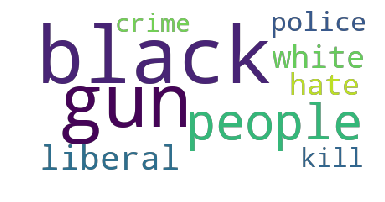

In [228]:
wc = WordCloud(background_color=None, max_words=10, mode='RGBA').generate(generate_wordcloud_string(lda_07, 2))
plt.axis('off')
plt.imshow(wc);

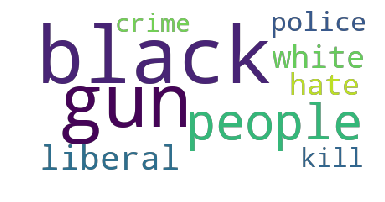

In [229]:
plt.axis('off')
plt.imshow(wc)
plt.savefig('ar_blacks_police.png', format='png', dpi=600);

In [286]:
lda_07.print_topics()

[(0,
  '0.011*"government" + 0.008*"pay" + 0.007*"war" + 0.007*"work" + 0.007*"free" + 0.006*"american" + 0.006*"tax" + 0.006*"money" + 0.005*"business" + 0.005*"right"'),
 (1,
  '0.048*"trump" + 0.017*"hillary" + 0.015*"vote" + 0.014*"clinton" + 0.011*"obama" + 0.009*"president" + 0.009*"speech" + 0.008*"state" + 0.007*"party" + 0.007*"democrat"'),
 (2,
  '0.017*"black" + 0.015*"gun" + 0.013*"just" + 0.013*"people" + 0.012*"liberal" + 0.010*"white" + 0.009*"hate" + 0.008*"police" + 0.008*"kill" + 0.007*"crime"'),
 (3,
  '0.023*"people" + 0.013*"right" + 0.012*"like" + 0.011*"think" + 0.011*"just" + 0.010*"say" + 0.008*"muslim" + 0.008*"make" + 0.007*"god" + 0.007*"know"'),
 (4,
  '0.014*"year" + 0.013*"time" + 0.010*"know" + 0.008*"just" + 0.007*"day" + 0.006*"make" + 0.006*"work" + 0.006*"money" + 0.006*"good" + 0.005*"come"'),
 (5,
  '0.020*"like" + 0.018*"man" + 0.013*"woman" + 0.013*"say" + 0.012*"good" + 0.011*"child" + 0.011*"look" + 0.010*"kid" + 0.009*"kristol" + 0.009*"just"'

##### The LDA model with 7 topics appears to make the most sense (1 non-sensical topic -- number 4 -- and 6 topics that can be understood in human contexts.

##### Our topics are:
0. American Government Macro Issues
1. Presidential Elections
2. African Americans and the Police
3. Religion (Islam)
4. N/A
5. Family / Gender Issues
6. White Nationalism

In [287]:
lda_09.print_topics()

[(0,
  '0.020*"muslim" + 0.014*"world" + 0.014*"speech" + 0.013*"war" + 0.009*"europe" + 0.009*"free" + 0.007*"christian" + 0.007*"fight" + 0.007*"america" + 0.007*"european"'),
 (1,
  '0.017*"man" + 0.015*"woman" + 0.012*"child" + 0.010*"kid" + 0.009*"like" + 0.009*"year" + 0.009*"just" + 0.007*"want" + 0.007*"old" + 0.007*"good"'),
 (2,
  '0.022*"people" + 0.020*"right" + 0.015*"good" + 0.010*"think" + 0.010*"just" + 0.008*"thing" + 0.007*"conservative" + 0.007*"liberal" + 0.007*"like" + 0.006*"party"'),
 (3,
  '0.014*"school" + 0.012*"college" + 0.011*"student" + 0.010*"jew" + 0.009*"high" + 0.009*"gorilla" + 0.009*"university" + 0.008*"campus" + 0.007*"jewish" + 0.006*"good"'),
 (4,
  '0.070*"white" + 0.027*"black" + 0.022*"gun" + 0.021*"people" + 0.009*"crime" + 0.009*"zoo" + 0.008*"race" + 0.008*"hate" + 0.008*"non" + 0.007*"class"'),
 (5,
  '0.024*"say" + 0.020*"know" + 0.013*"just" + 0.009*"money" + 0.009*"read" + 0.009*"lie" + 0.008*"people" + 0.008*"like" + 0.007*"think" + 0.

In [288]:
lda_11.print_topics()

[(0,
  '0.027*"people" + 0.016*"make" + 0.011*"god" + 0.008*"like" + 0.008*"use" + 0.007*"world" + 0.007*"word" + 0.006*"believe" + 0.006*"say" + 0.006*"just"'),
 (1,
  '0.046*"white" + 0.030*"like" + 0.028*"man" + 0.021*"woman" + 0.020*"look" + 0.020*"people" + 0.013*"just" + 0.012*"good" + 0.009*"look like" + 0.009*"think"'),
 (2,
  '0.028*"right" + 0.028*"vote" + 0.024*"trump" + 0.014*"party" + 0.013*"democrat" + 0.012*"conservative" + 0.012*"liberal" + 0.011*"white" + 0.011*"left" + 0.010*"want"'),
 (3,
  '0.021*"gun" + 0.020*"say" + 0.018*"speech" + 0.017*"beck" + 0.016*"free" + 0.015*"law" + 0.013*"know" + 0.011*"police" + 0.009*"hate" + 0.008*"kill"'),
 (4,
  '0.015*"kristol" + 0.015*"think" + 0.011*"right" + 0.011*"know" + 0.011*"just" + 0.011*"say" + 0.011*"thing" + 0.010*"good" + 0.010*"milo" + 0.008*"make"'),
 (5,
  '0.020*"country" + 0.014*"american" + 0.012*"america" + 0.010*"people" + 0.009*"muslim" + 0.009*"world" + 0.008*"government" + 0.008*"state" + 0.007*"eu" + 0.006

##### Now that we have our topics for each LDA model, let's cluster and look at the clustering metrics to determine the best result

In [289]:
# generate a corpus for each model
lda_05_corpus = lda_05[corpus]
lda_07_corpus = lda_07[corpus]
lda_09_corpus = lda_09[corpus]
lda_11_corpus = lda_11[corpus]

In [290]:
# get a list of docs for each model
lda_05_docs = [doc for doc in lda_05_corpus]
lda_07_docs = [doc for doc in lda_07_corpus]
lda_09_docs = [doc for doc in lda_09_corpus]
lda_11_docs = [doc for doc in lda_11_corpus]

In [319]:
# we need to get a x by y matrix for each model, where y is the number of topics and x is the number of documents
means_11_matrix = []

for doc in lda_11_docs:
    doc_matrix = []
    for i in range(11):
        topic_found = False
        for topic in doc:
            if int(topic[0]) == i:
                doc_matrix.append(topic[1])
                topic_found = True
        if not topic_found:
            doc_matrix.append(0)
        
    means_11_matrix.append(doc_matrix)

In [320]:
# convert each matrix to a numpy array for KMeans use
means_05_matrix = np.array(means_05_matrix)
means_07_matrix = np.array(means_07_matrix)
means_09_matrix = np.array(means_09_matrix)
means_11_matrix = np.array(means_11_matrix)

In [322]:
# confirm correct shape
print(means_05_matrix.shape)
print(means_07_matrix.shape)
print(means_09_matrix.shape)
print(means_11_matrix.shape)

(135461, 5)
(135461, 7)
(135461, 9)
(135461, 11)


In [323]:
# initialize our KMeans scoring metrics
inertias_05 = []
inertias_07 = []
inertias_09 = []
inertias_11 = []
silhouettes_05 = []
silhouettes_07 = []
silhouettes_09 = []
silhouettes_11 = []

In [324]:
# generate our KMeans models for each LDA model and get the resulting scoring metrics
for _ in range(4):
    inertias = []
    silhouettes = []
    
    if _ == 0:
        means_np_matrix = means_05_matrix
    elif _ == 1:
        means_np_matrix = means_07_matrix
    elif _ == 2:
        means_np_matrix = means_09_matrix
    else:
        means_np_matrix = means_11_matrix
        
    for i in range(2,13):
        km_loop = KMeans(n_clusters=i)
        km_loop.fit(means_np_matrix)
        inertias.append(km_loop.inertia_)
        silhouettes_loop = []
        for j in range(3):
            silhouettes_loop.append(silhouette_score(means_np_matrix, labels=km_loop.labels_, sample_size=20000))
        silhouettes.append(np.mean(silhouettes_loop))
        
    if _ == 0:
        inertias_05 = inertias
        silhouettes_05 = silhouettes
    elif _ == 1:
        inertias_07 = inertias
        silhouettes_07 = silhouettes
    elif _ == 2:
        inertias_09 = inertias
        silhouettes_09 = silhouettes
    else:
        inertias_11 = inertias
        silhouettes_11 = silhouettes
        
print('DONE.')

DONE.


In [463]:
# pickle LDA matrices
pickle.dump(means_05_matrix, open("pickle_files/means_05_matrix.pickle", "wb"))
pickle.dump(means_07_matrix, open("pickle_files/means_07_matrix.pickle", "wb"))
pickle.dump(means_09_matrix, open("pickle_files/means_09_matrix.pickle", "wb"))
pickle.dump(means_11_matrix, open("pickle_files/means_11_matrix.pickle", "wb"))

In [37]:
# load pickled files
means_05_matrix = pickle.load(open('pickle_files/means_05_matrix.pickle', 'rb'))
means_07_matrix = pickle.load(open('pickle_files/means_07_matrix.pickle', 'rb'))
means_09_matrix = pickle.load(open('pickle_files/means_09_matrix.pickle', 'rb'))
means_11_matrix = pickle.load(open('pickle_files/means_11_matrix.pickle', 'rb'))

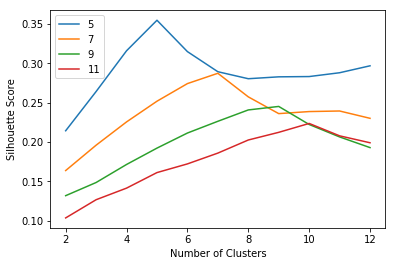

In [325]:
# let's take a look at the model silhouette scores by cluster number
plt.plot(range(2,13), silhouettes_05, label='5')
plt.plot(range(2,13), silhouettes_07, label='7')
plt.plot(range(2,13), silhouettes_09, label='9')
plt.plot(range(2,13), silhouettes_11, label='11')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend();

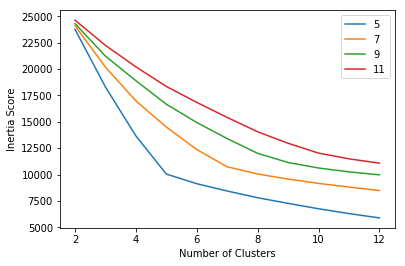

In [326]:
# let's take a look at the model inertia scores by cluster number
plt.plot(range(2,13), inertias_05, label='5')
plt.plot(range(2,13), inertias_07, label='7')
plt.plot(range(2,13), inertias_09, label='9')
plt.plot(range(2,13), inertias_11, label='11')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.legend();

In [370]:
km_altright = KMeans(n_clusters=5)

In [371]:
km_altright.fit(means_05_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Let's try deminsionality reduction with truncated SVD (a.k.a. LSA)

In [332]:
# let's transform our count vectorized matrix into a TF-IDF version
tf_idf = TfidfTransformer()
X_tfidf = tf_idf.fit_transform(X)

In [328]:
# generate our SVD model object with 100 componenets
trunc_SVD = TruncatedSVD(n_components=100)

In [333]:
# fit our model on our matrix
X_tfidf_transformed = trunc_SVD.fit_transform(X_tfidf)

In [361]:
# how much of the variance is explained by our 100 components?
print(trunc_SVD.explained_variance_ratio_.sum())

0.100559099153


##### Since 100 components explain only around 10% of our variance, TF-IDF SVD does not appear to be very effective in explaining our data, so let's move on and try NMF

# Deminsionality reduction with NMF

In [413]:
# generate our NMF model objects
nmf_05 = NMF(n_components=5)
nmf_07 = NMF(n_components=7)
nmf_09 = NMF(n_components=9)
nmf_11 = NMF(n_components=11)

In [415]:
# NMF returns two decomposed matrices, which we get here
W_05 = nmf_05.fit_transform(X_tfidf)
H_05 = nmf_05.components_
W_07 = nmf_07.fit_transform(X_tfidf)
H_07 = nmf_07.components_
W_09 = nmf_09.fit_transform(X_tfidf)
H_09 = nmf_09.components_
W_11 = nmf_11.fit_transform(X_tfidf)
H_11 = nmf_11.components_

In [416]:
def generate_topic_words(H_matrix):
    NMF_topics = []
    NMF_topics_sorted = []
    
    for topic in H_matrix:
        topic_dict = {}
        for i in range(len(topic)):
            topic_dict[id2word[i]] = topic[i]
        NMF_topics.append(topic_dict)
    
    for topic in NMF_topics:
        topic_sorted = sorted(topic.items(), key=operator.itemgetter(1))
        topic_sorted.reverse()
        topic_sorted = topic_sorted[:20]
        NMF_topics_sorted.append(topic_sorted)
    
    return NMF_topics_sorted

In [417]:
NMF_05_topics = generate_topic_words(H_05)
NMF_07_topics = generate_topic_words(H_07)
NMF_09_topics = generate_topic_words(H_09)
NMF_11_topics = generate_topic_words(H_11)

In [418]:
NMF_05_topics

[[('think', 1.3029631140029765),
  ('people', 1.2837408924831792),
  ('good', 1.2583577032160893),
  ('just', 1.2530294478159103),
  ('say', 1.2343350579667034),
  ('know', 1.2272235433000023),
  ('make', 1.0860527852331054),
  ('time', 0.84708299210179983),
  ('want', 0.83428166681812754),
  ('thing', 0.70720240731116935),
  ('year', 0.68017441937698231),
  ('way', 0.65361491030423091),
  ('work', 0.63627109806465609),
  ('come', 0.62147616759601199),
  ('use', 0.57196094121782026),
  ('really', 0.55938374690891046),
  ('man', 0.55642155535823246),
  ('country', 0.54618798553648029),
  ('mean', 0.48199283658183834),
  ('muslim', 0.48060630080150224)],
 [('white', 4.0533298774181992),
  ('black', 1.068495156670342),
  ('white people', 0.6274280505623181),
  ('non', 0.57241465144892167),
  ('non white', 0.5362700065980528),
  ('people', 0.52917292277028838),
  ('anti', 0.45401965882983564),
  ('anti white', 0.39311538037820803),
  ('race', 0.36166188700785323),
  ('white man', 0.3214741

In [419]:
NMF_07_topics

[[('people', 1.4145861130227695),
  ('good', 1.3966060155298923),
  ('just', 1.3884322048160203),
  ('say', 1.3770883443111945),
  ('know', 1.3535575769174411),
  ('make', 1.1995049796283965),
  ('time', 0.92709810623448552),
  ('want', 0.919066193698858),
  ('year', 0.72709583164875369),
  ('thing', 0.72458418372912337),
  ('work', 0.69723234557019864),
  ('come', 0.68309335904868396),
  ('way', 0.6827115953760049),
  ('use', 0.62968926025022898),
  ('country', 0.60797808523248709),
  ('man', 0.60694948733147713),
  ('really', 0.54593547729827419),
  ('muslim', 0.53162239947246381),
  ('american', 0.52866369791064005),
  ('world', 0.52376006868894209)],
 [('white', 4.1505687390216135),
  ('white people', 0.65175285252552373),
  ('non', 0.59755785883234058),
  ('people', 0.56749747370236969),
  ('non white', 0.56572054521054149),
  ('anti', 0.48086855617130292),
  ('anti white', 0.41702090515173462),
  ('race', 0.33688699575840969),
  ('white man', 0.32753961759808625),
  ('man', 0.276

In [424]:
NMF_09_topics

[[('people', 1.6018994484958735),
  ('good', 1.5561439422594461),
  ('just', 1.4504839337186375),
  ('make', 1.3348092780114058),
  ('time', 1.0163877896865718),
  ('want', 0.97136823754934354),
  ('year', 0.80076358231477796),
  ('work', 0.77825547919161375),
  ('way', 0.74946964033605767),
  ('come', 0.71642866416947348),
  ('country', 0.70477600971892784),
  ('use', 0.68315376042188181),
  ('thing', 0.68229745431714139),
  ('man', 0.6447751814295809),
  ('american', 0.61057915589199352),
  ('muslim', 0.59465199857324991),
  ('world', 0.59454644142118884),
  ('woman', 0.58673697207959963),
  ('really', 0.53237230383254375),
  ('point', 0.51642621285216317)],
 [('white', 4.124909411915012),
  ('white people', 0.63760762735204779),
  ('non', 0.59071601175897859),
  ('non white', 0.56268408077994914),
  ('people', 0.51060209523173095),
  ('anti', 0.47595268150486225),
  ('anti white', 0.41527621235368117),
  ('race', 0.32818636444200799),
  ('white man', 0.32487969335380523),
  ('pro', 

In [421]:
NMF_11_topics

[[('people', 1.9209710721371613),
  ('just', 1.7427547146871243),
  ('make', 1.4383267375024116),
  ('time', 1.1125273837203737),
  ('want', 1.0792562566631931),
  ('year', 0.85921680546430435),
  ('country', 0.8155547383026378),
  ('work', 0.79351066849007823),
  ('way', 0.7917908954652576),
  ('come', 0.78189158891047994),
  ('use', 0.75595623046310745),
  ('american', 0.71899974174455439),
  ('world', 0.65129129216319903),
  ('jew', 0.61342892722404119),
  ('state', 0.59217424713881661),
  ('thing', 0.57749055742140143),
  ('muslim', 0.57172841817383513),
  ('try', 0.56311242833128528),
  ('really', 0.55035994735682847),
  ('need', 0.51076285938264121)],
 [('white', 4.1213933067911839),
  ('white people', 0.62721990023764052),
  ('non', 0.59118366068598616),
  ('non white', 0.56664802236907053),
  ('anti', 0.47465119329860195),
  ('people', 0.4637983675956287),
  ('anti white', 0.4200968615346618),
  ('race', 0.32302026213441049),
  ('pro', 0.26854272355375991),
  ('pro white', 0.24

In [428]:
# generate our KMeans models for each LDA model and get the resulting scoring metrics
def generate_NMF_kmeans_scores(W_matrix):
    inertias = []
    silhouettes = []
    
    for i in range(2,13):
        km_loop = KMeans(n_clusters=i)
        km_loop.fit(W_matrix)
        inertias.append(km_loop.inertia_)
        silhouettes_loop = []
        for j in range(3):
            silhouettes_loop.append(silhouette_score(W_matrix, labels=km_loop.labels_, sample_size=20000))
        silhouettes.append(np.mean(silhouettes_loop))
        
    return inertias, silhouettes

In [429]:
kmeans_NMF_05_scores = generate_NMF_kmeans_scores(W_05)

In [431]:
kmeans_NMF_07_scores = generate_NMF_kmeans_scores(W_07)
kmeans_NMF_09_scores = generate_NMF_kmeans_scores(W_09)
kmeans_NMF_11_scores = generate_NMF_kmeans_scores(W_11)

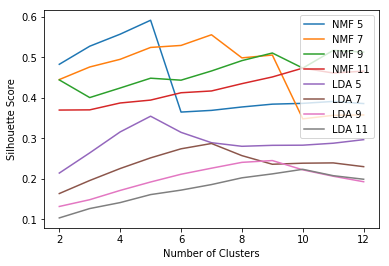

In [435]:
# let's take a look at the model silhouette scores by cluster number
plt.plot(range(2,13), kmeans_NMF_05_scores[1], label='NMF 5')
plt.plot(range(2,13), kmeans_NMF_07_scores[1], label='NMF 7')
plt.plot(range(2,13), kmeans_NMF_09_scores[1], label='NMF 9')
plt.plot(range(2,13), kmeans_NMF_11_scores[1], label='NMF 11')
plt.plot(range(2,13), silhouettes_05, label='LDA 5')
plt.plot(range(2,13), silhouettes_07, label='LDA 7')
plt.plot(range(2,13), silhouettes_09, label='LDA 9')
plt.plot(range(2,13), silhouettes_11, label='LDA 11')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend();

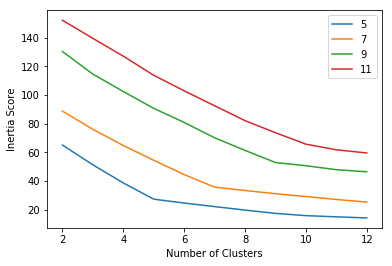

In [433]:
# let's take a look at the model inertia scores by cluster number
plt.plot(range(2,13), kmeans_NMF_05_scores[0], label='5')
plt.plot(range(2,13), kmeans_NMF_07_scores[0], label='7')
plt.plot(range(2,13), kmeans_NMF_09_scores[0], label='9')
plt.plot(range(2,13), kmeans_NMF_11_scores[0], label='11')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.legend();

##### While LDA has a much smaller average silhouette score, the topics from the LDA_05 model make way more sense than the topics from the NMF_05 model, so we will use LDA.

#### Let's try hierarchical clustering to see if that impacts our results

# Hierarchical Clustering

In [3]:
# generate our ward model object
ward = AgglomerativeClustering(linkage='ward', n_clusters=5)

In [5]:
# since getting memory erroes with entire matrix, shuffle our data so we can then take a random subset
np.random.shuffle(means_05_matrix)

In [6]:
# fit and predict on smaller set of data
ward_predict = ward.fit_predict(means_05_matrix[:50000,:])

In [7]:
# calculate silhouette score as a performance measure of our clustering
silhouette_score(means_05_matrix[:50000,:], labels=ward.labels_)

0.26066411977609855

In [8]:
# let's try Agglomerative Clustering again, but with different parameters
average_euc = AgglomerativeClustering(linkage='average', n_clusters=5)
average_man = AgglomerativeClustering(linkage='average', n_clusters=5, affinity='manhattan')

In [9]:
# fit our models
average_euc.fit(means_05_matrix[:50000,:])
average_man.fit(means_05_matrix[:50000,:])

AgglomerativeClustering(affinity='manhattan', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=5,
            pooling_func=<function mean at 0x7f427016eae8>)

In [10]:
# how do they do?
print(silhouette_score(means_05_matrix[:50000,:], labels=average_euc.labels_))
print(silhouette_score(means_05_matrix[:50000,:], labels=average_man.labels_))

0.263524544177
0.285710033145


##### The silhouette scores are worse than the ones found using traditional KMeans clustering, so I will use those for my main results

# Examine comments by topic clustering

In [38]:
# create our model object
km_altright = KMeans(n_clusters=7)

In [39]:
km_altright_predict = km_altright.fit_predict(means_07_matrix)

In [49]:
# group our comments by predicted cluster
comment_clusters = defaultdict(list)

for i in range(len(altright_text_list)):
    comment_clusters[km_altright_predict[i]].append(altright_text_list[i])

In [75]:
# how many comment are in each cluster?
for i in range(len(comment_clusters.keys())):
    print(i, ':', len(comment_clusters[i]))

0 : 16786
1 : 15530
2 : 14368
3 : 23428
4 : 18093
5 : 20279
6 : 26977


In [77]:
for i in range(len(comment_clusters.keys())):
    for _ in range(10):
        pprint.pprint(str(i) + ': ' + comment_clusters[i][random.randint(0, len(comment_clusters[i]))])
        print('\n')

('0: although i agree to a degree this be precisely what both the globalist '
 'socializtsas and neocon do they use both religion and stupidity in their '
 'proxy war for hegemony ')


('0: if french value his pathetic boot lick career he good say no and with '
 "conservative republican 's like these tool who need democrat liberal or "
 'progressive ')


('0: the tendency of the republican to pander to corporate interest and their '
 'lust for cheap labour and population growth represent an existential threat '
 'to white their tendency to zionist white anting be anotherthere be a part of '
 'the zionist lobby worry by the democrat politically correct leave go roque '
 'and abandon israel the solution neo - conservatism there be a part of the '
 'zionist lobby worry that trump will stop the eurocide and brazilification of '
 'america they be tear about who to support ')


('0: sure it be a shakedown by the obama regime but if elect official refuse '
 'to even try to fight against it or

In [107]:
km_altright_df = pd.DataFrame(data=km_altright.cluster_centers_, columns=['American Macro', 'Pres. Election', 'Blacks Police', 'Religion (Islam)', 'N/A', 'Family Gender', 'White Nationalism'])

In [114]:
km_altright_df

,American Macro,Pres. Election,Blacks Police,Religion (Islam),N/A,Family Gender,White Nationalism
0,0.074905,0.479992,0.074350,0.097516,0.115267,0.081182,0.070187
1,0.403147,0.088289,0.074265,0.116261,0.126145,0.098765,0.087718
2,0.068780,0.070168,0.486219,0.087206,0.101969,0.101112,0.078143
3,0.076362,0.071134,0.073596,0.094631,0.519322,0.093316,0.066018
4,0.074327,0.069088,0.081856,0.147596,0.083913,0.102612,0.433683
5,0.070799,0.058003,0.073388,0.096250,0.103367,0.513479,0.078921
6,0.076450,0.067841,0.066022,0.522863,0.091297,0.081155,0.087625


##### Now let's redo this process for the Social Justice Left

In [80]:
# Generate countVectorizer object, with stop words and a requirement that the words show up at least once
count_vectorizer_sjl = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))

In [81]:
# Fit the vectorizer on the comment list
X_sjl = count_vectorizer_sjl.fit_transform(sjleft_text_list)

In [82]:
# Get the corpus object to be used in LDA
counts_sjl = count_vectorizer_sjl.transform(sjleft_text_list).transpose()
corpus_sjl = gensim.matutils.Sparse2Corpus(counts_sjl)

In [83]:
# also map the words to their id's, so we can print the results in a human readable format
id2word_sjl = dict((v, k) for k, v in count_vectorizer_sjl.vocabulary_.items())

In [88]:
# these models take forever to generate, so we'll run them and then pickle them immediately for potential future use
lda_sjl_05 = gensim.models.LdaModel(corpus=corpus_sjl, num_topics=5,  id2word=id2word_sjl, passes=10)

In [91]:
lda_sjl_07 = gensim.models.LdaModel(corpus=corpus_sjl, num_topics=7,  id2word=id2word_sjl, passes=10)

In [95]:
lda_sjl_09 = gensim.models.LdaModel(corpus=corpus_sjl, num_topics=9,  id2word=id2word_sjl, passes=10)

In [90]:
# pickle LDA models
pickle.dump(lda_sjl_05, open("pickle_files/lda_sjl_05.pickle", "wb"))
pickle.dump(lda_sjl_07, open("pickle_files/lda_sjl_07.pickle", "wb"))
pickle.dump(lda_sjl_09, open("pickle_files/lda_sjl_09.pickle", "wb"))

In [36]:
# load pickled files
lda_sjl_05 = pickle.load(open('pickle_files/lda_sjl_05.pickle', 'rb'))
lda_sjl_07 = pickle.load(open('pickle_files/lda_sjl_07.pickle', 'rb'))
lda_sjl_09 = pickle.load(open('pickle_files/lda_sjl_09.pickle', 'rb'))

In [99]:
lda_sjl_05.print_topics()

[(0,
  '0.024*"gay" + 0.013*"man" + 0.008*"woman" + 0.008*"people" + 0.007*"white" + 0.007*"use" + 0.006*"black" + 0.006*"sex" + 0.005*"year" + 0.005*"community"'),
 (1,
  '0.021*"just" + 0.021*"say" + 0.019*"like" + 0.016*"think" + 0.014*"know" + 0.010*"thing" + 0.010*"good" + 0.009*"time" + 0.009*"make" + 0.009*"look"'),
 (2,
  '0.024*"vote" + 0.022*"hillary" + 0.017*"clinton" + 0.011*"candidate" + 0.010*"win" + 0.009*"election" + 0.008*"support" + 0.007*"state" + 0.006*"party" + 0.006*"bernie"'),
 (3,
  '0.040*"trump" + 0.009*"lie" + 0.008*"say" + 0.008*"make" + 0.006*"donald" + 0.006*"news" + 0.006*"money" + 0.005*"pay" + 0.005*"want" + 0.005*"bad"'),
 (4,
  '0.027*"people" + 0.017*"right" + 0.008*"law" + 0.007*"make" + 0.007*"want" + 0.006*"think" + 0.006*"good" + 0.006*"republican" + 0.006*"party" + 0.005*"issue"')]

In [100]:
lda_sjl_07.print_topics()

[(0,
  '0.038*"gay" + 0.033*"people" + 0.015*"like" + 0.013*"man" + 0.012*"say" + 0.011*"just" + 0.009*"good" + 0.009*"think" + 0.008*"know" + 0.008*"thing"'),
 (1,
  '0.031*"trump" + 0.017*"hillary" + 0.016*"clinton" + 0.012*"say" + 0.010*"donald" + 0.010*"president" + 0.008*"lie" + 0.008*"obama" + 0.007*"tell" + 0.007*"question"'),
 (2,
  '0.010*"year" + 0.010*"work" + 0.008*"state" + 0.008*"time" + 0.007*"pay" + 0.007*"long" + 0.006*"new" + 0.006*"law" + 0.006*"make" + 0.006*"money"'),
 (3,
  '0.020*"right" + 0.011*"think" + 0.010*"good" + 0.009*"use" + 0.008*"know" + 0.008*"word" + 0.008*"straight" + 0.007*"point" + 0.006*"way" + 0.006*"just"'),
 (4,
  '0.014*"white" + 0.011*"right" + 0.010*"black" + 0.010*"lgbt" + 0.009*"people" + 0.008*"anti" + 0.008*"country" + 0.007*"american" + 0.007*"christian" + 0.006*"community"'),
 (5,
  '0.021*"just" + 0.020*"say" + 0.019*"like" + 0.015*"think" + 0.015*"make" + 0.011*"look" + 0.010*"comment" + 0.009*"know" + 0.009*"post" + 0.008*"read"'),

In [101]:
lda_sjl_09.print_topics()

[(0,
  '0.014*"gun" + 0.010*"law" + 0.009*"use" + 0.008*"year" + 0.008*"kill" + 0.008*"crime" + 0.007*"police" + 0.007*"shoot" + 0.006*"people" + 0.005*"year old"'),
 (1,
  '0.017*"know" + 0.016*"time" + 0.012*"come" + 0.011*"good" + 0.011*"think" + 0.009*"just" + 0.009*"love" + 0.008*"like" + 0.008*"make" + 0.008*"really"'),
 (2,
  '0.032*"right" + 0.013*"state" + 0.009*"government" + 0.009*"law" + 0.008*"country" + 0.006*"support" + 0.006*"court" + 0.005*"public" + 0.005*"war" + 0.005*"wing"'),
 (3,
  '0.031*"vote" + 0.028*"hillary" + 0.024*"trump" + 0.022*"party" + 0.021*"clinton" + 0.018*"republican" + 0.014*"candidate" + 0.013*"win" + 0.012*"election" + 0.011*"support"'),
 (4,
  '0.044*"trump" + 0.030*"say" + 0.011*"racist" + 0.010*"donald" + 0.008*"make" + 0.007*"moslem" + 0.007*"just" + 0.007*"know" + 0.006*"gay man" + 0.006*"lie"'),
 (5,
  '0.031*"like" + 0.026*"just" + 0.024*"say" + 0.016*"think" + 0.014*"make" + 0.014*"thing" + 0.010*"read" + 0.010*"look" + 0.010*"post" + 0.0

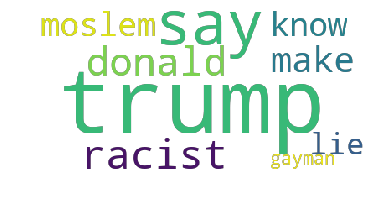

In [299]:
wc = WordCloud(background_color=None, max_words=10, mode='RGBA', prefer_horizontal=1).generate(generate_wordcloud_string(lda_sjl_09, 4))
plt.axis('off')
plt.imshow(wc);

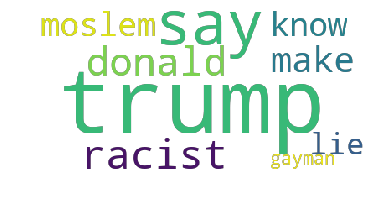

In [300]:
plt.axis('off')
plt.imshow(wc);
plt.savefig('sjl_trump_racism.png', format='png', dpi=600);

In [119]:
sjl_lda_09_corpus = lda_sjl_09[corpus_sjl]
sjl_lda_09_docs = [doc for doc in sjl_lda_09_corpus]

In [136]:
# we need to get a x by y matrix for our model, where y is the number of topics and x is the number of documents
sjl_means_09_matrix = []

for doc in sjl_lda_09_docs:
    doc_matrix = []
    for i in range(9):
        topic_found = False
        for topic in doc:
            if int(topic[0]) == i:
                doc_matrix.append(topic[1])
                topic_found = True
        if not topic_found:
            doc_matrix.append(0)
        
    sjl_means_09_matrix.append(doc_matrix)

In [137]:
sjl_means_09_matrix = np.array(sjl_means_09_matrix)

In [138]:
# generate our KMeans model for the LDA model and get the resulting scoring metrics
sjl_silhouettes = []

for i in range(2,13):
    km_loop = KMeans(n_clusters=i)
    km_loop.fit(sjl_means_09_matrix)
    silhouettes_loop = []
    for j in range(3):
        silhouettes_loop.append(silhouette_score(sjl_means_09_matrix, labels=km_loop.labels_, sample_size=20000))
    sjl_silhouettes.append(np.mean(silhouettes_loop))

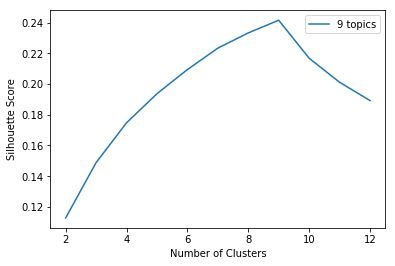

In [139]:
plt.plot(range(2,13), sjl_silhouettes, label='9 topics')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend();

In [140]:
# create our model object and predict clusters
km_sjl = KMeans(n_clusters=9)
km_sjl_predict = km_sjl.fit_predict(sjl_means_09_matrix)

In [141]:
# group our comments by predicted cluster
sjl_comment_clusters = defaultdict(list)

for i in range(len(sjleft_text_list)):
    sjl_comment_clusters[km_sjl_predict[i]].append(sjleft_text_list[i])

In [142]:
# how many comment are in each cluster?
for i in range(len(sjl_comment_clusters.keys())):
    print(i, ':', len(sjl_comment_clusters[i]))

0 : 23061
1 : 15025
2 : 10958
3 : 19154
4 : 10222
5 : 12040
6 : 13306
7 : 19203
8 : 17766


In [524]:
for doc in main_altright.find():
    if 'sound fascist' in doc['message']:
        print(doc['lemma_message'])

wow that do not sound fascist at all 


In [520]:
for doc in breitbart.find():
    if  '!' in doc['message'].lower() and len(doc['message']) < 75 and len(doc['message']) > 25:
        print(doc['message'] + '\n')

Larry the Cable Guy said if he got drunk enough he would go for it!

clearly world leaders have LOST THEIR MIND !!!!!!!!!!!

BWAHAHAHAHA...You mangina is showing!

SiriusXM doesn't really suspend anyone haha!

Good bye BECK!

Well that qualifies him.  Harvard!

The price of escargot just doubled!


This has to be legit!

Bwahahahahahahahahahahahahahahahaha!!!!!!!!!!!!!  What a tool!

He should have been sealed up in that vault !

Awesome!!  Good show Mr. Trump!!

My comment is awaiting a lot of moderation as I am a lady !

"tish that's french".....you know how I loathe the french!

"And you (guy from ABC) are a sleaze" !!!
LMAO

ah I think that's crepes.....on second thought you might be right!

Hey, Becky and crew, don't let the door hit you in the ass.  CYA!

I want to see Trump rip Wolf Blitzer a new one!!!

Wishes do come true!!  Looney beck has finally gone too far it seems.

Hillary bought stock already !!!!

Exactly! 

If our Constitution was in danger like it is now....

Still 

Oh, how times have changed! LMAO

The Never Trumps played an Ever Trump egg!

Thousands?  Millions of people!  Maybe billions!

Everything! French won't get 1% It's laughable.
FRENCH TOAST!

I sure as hell hope you're voting for Trump!

I am having SEX with my wife, I will watch it in a minute!

It's about time a troll chimed in!

I Must learn to read article !!!
My Bad :(
Just my $0.02

David French: Make America Cuck Again!

I smell a landslide coming!
TRUMP 2016

And Cruz was NEVER the nominee - the OFFICIAL nominee!!

ONLY President Donald TRUMP…Period. Krybaby Kristol can shove it!!

"You cannot have a revolution without Plan B!"

Brad Thor is THE douche bag! Keep digging, little man.

She  can only take so much...three Orgasms and she is done!

FOX has a winner not like that beech!

Kristol is a narcissistic, self-aggrandizing Azzzz Wipe! TRUMP16

That's just his candidates!

Facts?  We don't need no stinkin' facts!

I think you are right about that!

THE TRUMP CARD always beats 

CUCKACIDE: IT COULDN'T HAPPEN TO A MORE DESERVING PASSEL OF POOSIES!

Unbelievable! This is the reason Americans are taking back America.

As Churchill said "In the future, the anti-facists will be the facists!"

A mosquito is not an animal... but... OK! Too funny!

Math challenged?  March to May is TWO months, MORON!

French..the forgotten salad dressing nobody likes..TRUMP/USA!

One sheriff here reported a murder committed with a rock.  Register that!

Less than a month to a sovereign Britain!

I was JUST thinking the SAME thing!!

Who?  David, as in David & Goliath?

Wotta pair o' maroons!!

OH MY ALLAH!  It's Billy Bob's discharge pic from meth rehab...YEE-HAW!

Good News!  Let the deportations begin.

The graph clearly splits the two.  Nice try though!

OHohOHoh THAT guy! Kook out of the chute!

For sure these are paid shills. No one can possibly be that obtuse! 

Evidence Obama and his policies are failures!!

INSANITY! 
Our Queen Negro must be tried for Treason and shot!

"We're

In [319]:
for i in range(len(comment_clusters.keys())):
    for _ in range(10):
        pprint.pprint(str(i) + ': ' + comment_clusters[i][random.randint(0, len(comment_clusters[i]))])
        print('\n')

('0: thor understand the power of suggestion that be why he suggest that a '
 'patriot should take trump out or the sky will fall he and beck hop it would '
 'be a left - wing activist but could settle on a patriot as long as trump be '
 'murder everything be okay be i right bradbeck and thor be the one demonize '
 'trump actually ')


('0: so the recent poll show shrillarly will win by a landslide be lie that be '
 'not a surprise the msm be pay professional liar ')


('0: typical of a trump supportertrump be pull in so many people from all '
 'across the political spectrum from all demographic i be not sure there be a '
 'typical trump supporter ')


'0: finally something we can agree on i will even give you a white power '


'0: there no anyone fight bannon be a fucking neocon israel firster breitbart '


('0: this be the problem when a society allow foreigner in too great of '
 'numberstoo great of number mean they have sufficient number to affect vote '
 'outcomeswe be likely to s

In [145]:
km_sjl_df = pd.DataFrame(data=km_sjl.cluster_centers_, columns=['BLM Police', 'N/A', 'Rightwing Gov', 'Pres Election', 'Donald Racism', 'N/A', 'N/A', 'LGBTQ', 'Domestic Economics'])

In [147]:
km_sjl_df

,BLM Police,N/A,Rightwing Gov,Pres Election,Donald Racism,N/A,N/A,LGBTQ,Domestic Economics
0,0.052321,0.071123,0.064671,0.057041,0.065921,0.091562,0.455831,0.067977,0.061344
1,0.057799,0.455077,0.055920,0.057546,0.070348,0.081233,0.083402,0.064748,0.063933
2,0.059230,0.079387,0.072239,0.061556,0.061687,0.087748,0.095374,0.062297,0.410052
3,0.042536,0.081166,0.068480,0.468196,0.059631,0.090969,0.079651,0.040849,0.055316
4,0.385016,0.079658,0.075287,0.052566,0.073388,0.099368,0.099941,0.066909,0.057815
5,0.052207,0.065114,0.063046,0.069347,0.458580,0.073617,0.088209,0.061967,0.056753
6,0.058133,0.075680,0.060629,0.049545,0.074464,0.093406,0.112129,0.400669,0.063923
7,0.054182,0.067711,0.057640,0.060891,0.065861,0.477007,0.086773,0.062157,0.056407
8,0.064468,0.074635,0.364862,0.080626,0.069155,0.098103,0.105636,0.062671,0.069131


# Sentiment Analysis
Let's do a bit of sentiment analysis with NLTK

In [342]:
# sentiment analysis (positive, negative, neutral, compound) using nltk.sentiment.vader
ar_pos_nltk = []
ar_neg_nltk = []
ar_neu_nltk = []
ar_compound_nltk = []

sid = vader.SentimentIntensityAnalyzer()
for comment in altright_text_list:
    ss = sid.polarity_scores(comment)
    ar_pos_nltk.append(ss['pos'])
    ar_neg_nltk.append(ss['neg'])
    ar_neu_nltk.append(ss['neu'])
    ar_compound_nltk.append(ss['compound'])

In [363]:
pos_altright = []
neg_altright = []
neu_altright = []

for i in range(len(altright_text_list)):
    if ar_neu_nltk[i] > 0.90:
        neu_altright.append([i, ar_neu_nltk[i], altright_text_list[i]])
    elif ar_pos_nltk[i] - ar_neg_nltk[i] > 0.0:
        pos_altright.append([i, ar_pos_nltk[i] - ar_neg_nltk[i], altright_text_list[i]])
    else:
        neg_altright.append([i, ar_pos_nltk[i] - ar_neg_nltk[i], altright_text_list[i]])

In [417]:
total_ar_sentiment = len(pos_altright) + len(neg_altright) + len(neu_altright)

print(len(pos_altright))
print(len(neg_altright))
print(len(neu_altright))
ar_pos_percent = (len(pos_altright) / total_ar_sentiment)
ar_neg_percent = (len(neg_altright) / total_ar_sentiment)
ar_neu_percent = (len(neu_altright) / total_ar_sentiment)

51600
53700
30161


In [403]:
pos_ar_values = [item[1] for item in pos_altright]
neg_ar_values = [item[1] for item in neg_altright]
neu_ar_values = [item[1] for item in neu_altright]

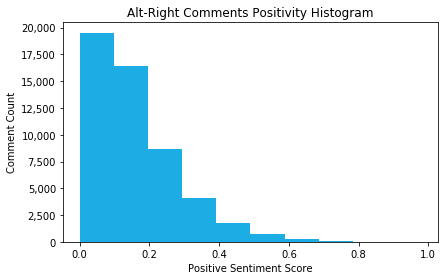

In [402]:
fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('0,000'))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Comment Count')
plt.title('Alt-Right Comments Positivity Histogram')
plt.tight_layout()
plt.hist(pos_ar_values, color='#1CADE4');

In [369]:
# sentiment analysis (positive, negative, neutral, compound) using nltk.sentiment.vader
sjl_pos_nltk = []
sjl_neg_nltk = []
sjl_neu_nltk = []
sjl_compound_nltk = []

sid = vader.SentimentIntensityAnalyzer()
for comment in sjleft_text_list:
    ss = sid.polarity_scores(comment)
    sjl_pos_nltk.append(ss['pos'])
    sjl_neg_nltk.append(ss['neg'])
    sjl_neu_nltk.append(ss['neu'])
    sjl_compound_nltk.append(ss['compound'])

In [370]:
pos_sjl = []
neg_sjl = []
neu_sjl = []

for i in range(len(sjleft_text_list)):
    if sjl_neu_nltk[i] > 0.90:
        neu_sjl.append([i, sjl_neu_nltk[i], sjleft_text_list[i]])
    elif sjl_pos_nltk[i] - sjl_neg_nltk[i] > 0.0:
        pos_sjl.append([i, sjl_pos_nltk[i] - sjl_neg_nltk[i], sjleft_text_list[i]])
    else:
        neg_sjl.append([i, sjl_pos_nltk[i] - sjl_neg_nltk[i], sjleft_text_list[i]])

In [418]:
total_sjl_sentiment = len(pos_sjl) + len(neg_sjl) + len(neu_sjl)

print(len(pos_sjl))
print(len(neg_sjl))
print(len(neu_sjl))
sjl_pos_percent = (len(pos_sjl) / total_sjl_sentiment)
sjl_neg_percent = (len(neg_sjl) / total_sjl_sentiment)
sjl_neu_percent = (len(neu_sjl) / total_sjl_sentiment)

55204
57252
28279


In [489]:
for comment in pos_sjl:
    if comment[1] > 0.9:
        print(comment)

[102509, 0.901, 'i wish you peace truly ']
[102669, 0.944, 'i love dog love love love ']
[107984, 0.956, 'ha ha ha ha ha ha ha ha ha categorically ']
[112712, 0.934, '  lovely wish them great happiness ']


##### Let's graph our sentiment results for use in the presentation

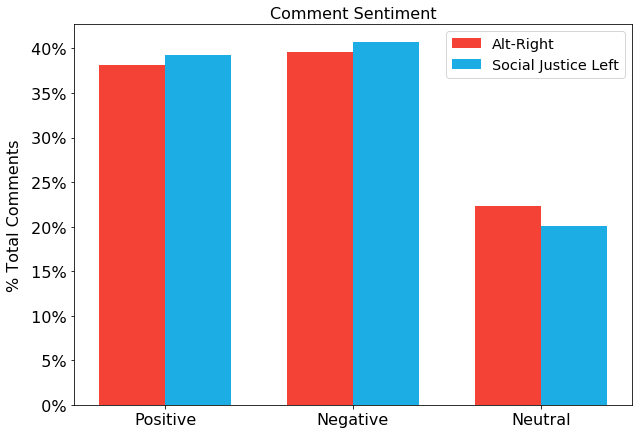

In [454]:
N = 3

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, [ar_pos_percent, ar_neg_percent, ar_neu_percent], width, color='#F44336')
rects2 = ax.bar(ind+width, [sjl_pos_percent, sjl_neg_percent, sjl_neu_percent], width, color='#1CADE4')

# add some
ax.set_ylabel('% Total Comments', fontsize=16)
ax.set_title('Comment Sentiment', fontsize=16)
ax.set_xticks(ind+width/2)
ax.set_xticklabels( ('Positive', 'Negative', 'Neutral'), fontsize=16 )
plt.yticks(fontsize=16)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

ax.legend( (rects1[0], rects2[0]), ('Alt-Right', 'Social Justice Left'), fontsize='x-large')

plt.show()